## **天猫重复购买预测**
***

### **第一部分：数据探索**

In [2]:
# 导入工具包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# 数据读取
test_data = pd.read_csv('./data_format1/test_format1.csv')
train_data = pd.read_csv('./data_format1/train_format1.csv')
user_info = pd.read_csv('./data_format1/user_info_format1.csv')   # 特征表
user_log = pd.read_csv('./data_format1/user_log_format1.csv')     # 日志信息

# user_info = pd.read_csv('./data_format1/user_info_format1.csv').drop_duplicates()
# user_log = pd.read_csv('./data_format1/user_log_format1.csv').rename(columns={'seller_id':'merchant_id'})

### **查看数据**

In [4]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [5]:
train_data.shape

(260864, 3)

In [6]:
test_data.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [7]:
test_data.shape

(261477, 3)

In [8]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [9]:
user_info.shape

(424170, 3)

In [10]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [11]:
user_log.shape

(54925330, 7)

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
user_id        260864 non-null int64
merchant_id    260864 non-null int64
label          260864 non-null int64
dtypes: int64(3)
memory usage: 6.0 MB


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
user_id        261477 non-null int64
merchant_id    261477 non-null int64
prob           0 non-null float64
dtypes: float64(1), int64(2)
memory usage: 6.0 MB


In [14]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
user_id      424170 non-null int64
age_range    421953 non-null float64
gender       417734 non-null float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [15]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
user_id        int64
item_id        int64
cat_id         int64
seller_id      int64
brand_id       float64
time_stamp     int64
action_type    int64
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


### **查看缺失值**

In [16]:
# 查看用户信息数据的缺失情况：user_info
(user_info.shape[0]-user_info["age_range"].count())/user_info.shape[0]     # age_range 的缺失率

0.005226677982884221

In [17]:
user_info[user_info["age_range"].isna()|user_info["age_range"]==0].count()   # 年龄缺失或者年龄缺省值0

user_id      92914
age_range    92914
gender       90638
dtype: int64

In [18]:
user_info.groupby(['age_range'])[['user_id']].count()   # 根据年龄区间对用户ID进行统计排序

,user_id
age_range,
0.0,92914
1.0,24
2.0,52871
3.0,111654
4.0,79991
5.0,40777
6.0,35464
7.0,6992
8.0,1266


In [19]:
# gender缺省情况
(user_info.shape[0]-user_info["gender"].count())/user_info.shape[0]

0.01517316170403376

In [20]:
# 性别缺失或缺省值统计量
user_info[user_info["gender"].isnull()|(user_info["gender"]==2)].count()

user_id      16862
age_range    14664
gender       10426
dtype: int64

In [21]:
user_info.groupby(["gender"])[["user_id"]].count()

,user_id
gender,
0.0,285638
1.0,121670
2.0,10426


In [22]:
# 查看日志数据的缺失情况
user_log.isnull().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

### **观察数据分布**

In [23]:
user_info.describe().T   # 查看总体数据统计信息

,count,mean,std,min,25%,50%,75%,max
user_id,424170.0,212085.500000,122447.476178,1.0,106043.25,212085.5,318127.75,424170.0
age_range,421953.0,2.930262,1.942978,0.0,2.00,3.0,4.00,8.0
gender,417734.0,0.341179,0.524112,0.0,0.00,0.0,1.00,2.0


In [24]:
# 查看正负样本分布
label_gp = train_data.groupby('label')['user_id'].count()
print('正负样本数量：\n',label_gp)

正负样本数量：
 label
0    244912
1     15952
Name: user_id, dtype: int64


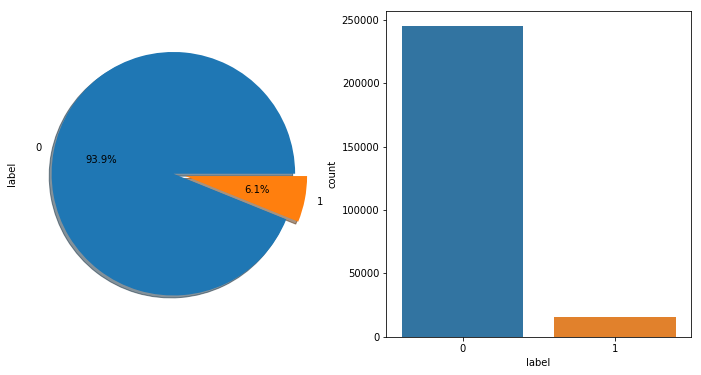

In [25]:
# 正负样本可视化
f,axe = plt.subplots(1,2,figsize=(12,6))
train_data.label.value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,explode=[0,0.1],ax=axe[0])
sns.countplot('label',data=train_data,ax=axe[1],)

### **探索影响复购的各种因素**

#### 1. 对店铺分析

用户复购可能受到店铺、用户、用户性别、用户年龄等因素的影响，逐一分析：

In [26]:
print('选取top5店铺\n店铺\t购买次数')
train_data.merchant_id.value_counts().head()    # 根据值对它进行统计

选取top5店铺
店铺	购买次数


4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64

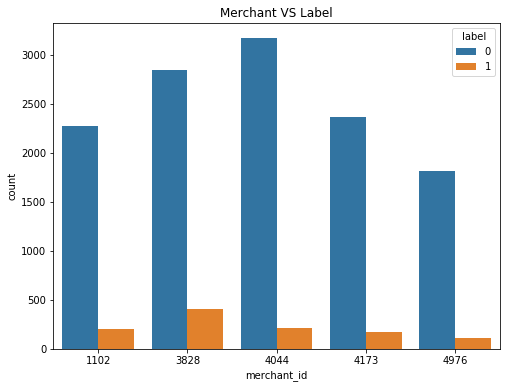

In [27]:
train_data_merchant = train_data.copy()   # 将训练数据复制一份
train_data_merchant['TOP5'] = train_data_merchant['merchant_id'].map(lambda x:1 if x in [4044,3828,4173,1102,4976] else 0)
train_data_merchant = train_data_merchant[train_data_merchant['TOP5']==1]
plt.figure(figsize=(8,6))
plt.title('Merchant VS Label')
sax = sns.countplot('merchant_id',hue='label',data=train_data_merchant)

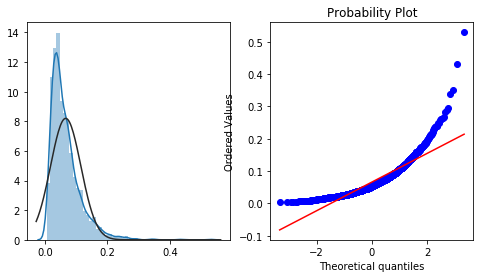

In [28]:
# 查看店铺的复购分布
merchant_repeat_buy = [rate for rate in train_data.groupby(['merchant_id'])['label'].mean() if rate <= 1 and rate > 0]
# 以merchant_id为准，label的均值，就是对每个merchant_id的所有label加起来求均值，算出复购率。
# 可以得出，店铺的复购分布不是正态的，不同的店铺有不同的复购概率，为0~0.3
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
sns.distplot(merchant_repeat_buy,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(merchant_repeat_buy,plot=plt)

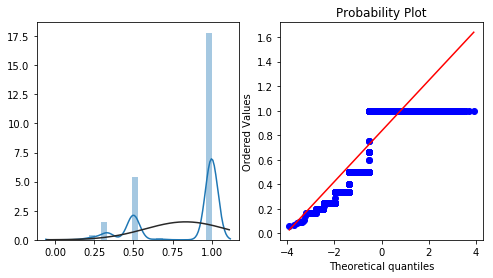

In [29]:
# 查看用户的复购分布
user_repeat_buy = [rate for rate in train_data.groupby(['user_id'])['label'].mean() if rate <= 1 and rate >0]
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
sns.distplot(user_repeat_buy,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(user_repeat_buy,plot=plt)

# 可以看出，用户6个月的复购概率很小，基本以买一次为主

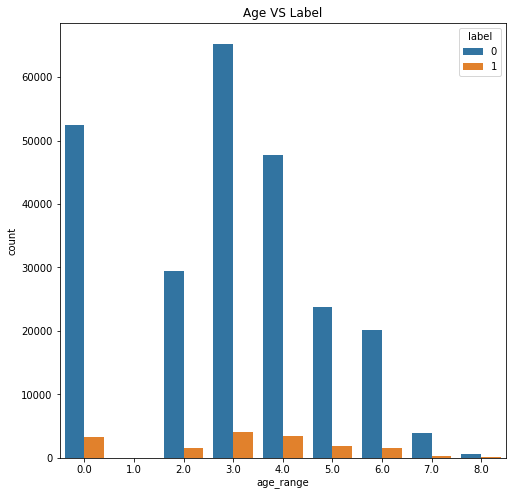

In [30]:
# 查看用户年龄复购关系
plt.figure(figsize=(8,8))
plt.title('Age VS Label')
train_data_user_info = train_data.merge(user_info,on=['user_id'],how='left')
ax = sns.countplot('age_range',hue='label',data=train_data_user_info)

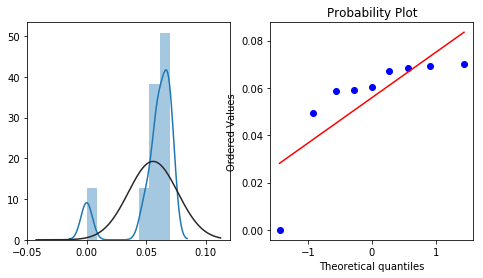

In [31]:
# 用户年龄复购分布
repeat_buy = [rate for rate in train_data_user_info.groupby(['age_range'])['label'].mean()]
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
sns.distplot(repeat_buy,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(repeat_buy,plot=plt)

# 可以看出，不同年龄段用户的复购概率不同

## **特征工程**
***

In [32]:
# 定义内存压缩的方法，对数值类型的特征字段选择合适的dtype
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [37]:
# num_rows = None
# # num_rows = 200 * 10000 # 1000条测试代码使用
# # num_rows = 1000

# train_file = './data_format1/train_format1.csv'
# test_file = './data_format1/test_format1.csv'

# user_info_file = './data_format1/user_info_format1.csv'
# user_log_file = './data_format1/user_log_format1.csv'

# train_data = reduce_mem_usage(read_csv(train_file, num_rows))
# test_data = reduce_mem_usage(read_csv(test_file, num_rows))

# user_info = reduce_mem_usage(read_csv(user_info_file, num_rows))
# user_log = reduce_mem_usage(read_csv(user_log_file, num_rows))

### **数据处理**


In [33]:
del test_data['prob']
all_data = train_data.append(test_data)
all_data = all_data.merge(user_info,on=['user_id'],how='left')
del train_data,test_data,user_info
import gc
gc.collect()

3420

In [35]:
all_data.head()

,label,merchant_id,user_id,age_range,gender
0,0.0,3906,34176,6.0,0.0
1,0.0,121,34176,6.0,0.0
2,1.0,4356,34176,6.0,0.0
3,0.0,2217,34176,6.0,0.0
4,0.0,4818,230784,0.0,0.0


In [36]:
all_data.shape

(522341, 5)

In [37]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 5 columns):
label          260864 non-null float64
merchant_id    522341 non-null int64
user_id        522341 non-null int64
age_range      519763 non-null float64
gender         514796 non-null float64
dtypes: float64(3), int64(2)
memory usage: 23.9 MB


In [41]:
all_data.isnull().sum()

label          261477
merchant_id         0
user_id             0
age_range        2578
gender           7545
dtype: int64

In [42]:
user_log = user_log.sort_values(['user_id','time_stamp'])

In [43]:
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
23288890,1,181459,276,2245,4750.0,1009,0
23288891,1,779078,276,2245,4750.0,1009,0
23288892,1,779078,276,2245,4750.0,1009,0
23288893,1,452837,276,2245,4750.0,1009,0
23288894,1,543397,276,2245,4750.0,1009,0


In [44]:
user_log.shape

(54925330, 7)

In [45]:
# 合并数据
list_join_func = lambda x: " ".join([str(i) for i in x])
agg_dict = {'item_id':list_join_func,
           'cat_id':list_join_func,
           'seller_id':list_join_func,
           'brand_id':list_join_func,
           'time_stamp':list_join_func,
           'action_type':list_join_func
           }
rename_dict = {
            'item_id' : 'item_path',
            'cat_id' : 'cat_path',
            'seller_id' : 'seller_path',
            'brand_id' : 'brand_path',
            'time_stamp' : 'time_stamp_path',
            'action_type' : 'action_type_path'
        }
user_log_path = user_log.groupby('user_id').agg(agg_dict).reset_index().rename(columns=rename_dict)

# groupby 没有进行任何运算，只是进行了一个分组。运算是对后面的值进行的。
# groupby(['a','b']),通过两个键对数据进行了分组，得到的 Series具有一个层次化索引（由唯一的键对组成）
# groupby + agg 可以对goupby的结果同时应用多个函数。
# 重要技巧： groupby之后直接.reset_index()可以得到一个没有多级索引的DataFrame
# 之后可以通过df.rename({‘old_col1’:‘new_col1’,‘old_col2’:‘new_col2’,…})重命名

In [46]:
user_log_path.head()

,user_id,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path
0,1,181459 779078 779078 452837 543397 504149 5041...,276 276 276 276 276 1023 1023 1023 1023 1252 1...,2245 2245 2245 2245 2245 925 925 925 925 4026 ...,4750.0 4750.0 4750.0 4750.0 4750.0 7402.0 7402...,1009 1009 1009 1009 1009 1011 1011 1011 1011 1...,0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 ...
1,2,348983 749563 239288 751744 239288 714176 1972...,177 177 602 602 602 1213 602 602 602 1213 1213...,2223 2223 420 420 420 420 420 420 420 420 420 ...,3273.0 3273.0 4953.0 4953.0 4953.0 4058.0 4953...,527 527 626 626 626 626 626 626 626 626 626 62...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 ...
2,3,895754 895754 182882 182882 985337 175397 9463...,1505 1505 1271 1271 1271 662 1134 1134 1134 45...,795 795 2123 2123 4925 1102 4461 4461 4461 474...,3608.0 3608.0 4796.0 4796.0 8005.0 1214.0 905....,516 516 627 627 627 727 819 819 820 906 906 90...,2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,4,836727 243874 185489 95474 30073 790055 790055...,612 1577 1505 1505 1505 1505 1505 1505 1505 15...,1221 1221 1221 1221 1221 1221 1221 1221 1221 1...,7734.0 7734.0 7734.0 7734.0 7734.0 7734.0 7734...,527 527 527 527 527 527 527 527 527 527 527 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,5,511956 728354 568450 754044 1011255 741215 362...,302 351 812 1213 142 464 1028 35 1213 351 142 ...,3098 3215 641 3736 1483 176 4848 641 3736 4547...,5545.0 5482.0 4265.0 3125.0 4640.0 6662.0 2803...,519 520 520 520 520 520 520 520 520 520 520 52...,3 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 ...


In [47]:
del user_log
gc.collect()

117

In [49]:
user_log_path.shape

(424170, 7)

## **定义特征统计函数**


定义统计数据的 总数

In [50]:
def cnt_(x):
    try:
        return len(x.split(' '))
    except:
        return -1

定义统计数据 唯一值  总数的函数

In [51]:
def nunique_(x):
    try:
        return len(set(x.split(' ')))
    except:
        return -1

定义统计数据  最大值  的函数

In [52]:
def max_(x):
    try:
        return np.max([float(i) for i in x.split(' ')])
    except:
        return -1

定义统计数据  最小值  的函数

In [53]:
def min_(x):
    try:
        return np.min([float(i) for i in x.split(' ')])
    except:
        return -1

定义统计数据  标准差  的函数

In [54]:
def std_(x):
    try:
        return np.std([float(i) for i in x.split(' ')])
    except:
        return -1

定义统计数据中 topN  数据的函数

In [55]:
def most_n_cnt(x,n):
    try:
        return Counter(x.split(' ')).most_common(n)[n-1][0]
    except:
        return -1

定义统计数据中topN 数据总数的函数

In [56]:
from collections import Counter
def most_n_cnt(x,n):
    try:
        return Counter(x.split(' ')).most_common(n)[n-1][1]  # 返回的是一个列表，列表里是元组，为（元素，次数）
    except:
        return -1
# [n-1]是取list中前n-1个元素，[1]表示我们只要知道这个元素的数量。若为[0]则表示取元素。

调用定义的统计函数

In [66]:
# 统计用户日志里面某一列，即某一个特征下总次数，生成新的特征列，命名为name
def user_cnt(df_data,single_col,name):
    df_data[name] = df_data[single_col].apply(cnt_)
    return df_data

def user_nunique(df_data,single_col,name):
    df_data[name] = df_data[single_col].apply(nunique_)
    return df_data
def user_max(df_data,single_col,name):
    df_data[name] = df_data[single_col].apply(max_)
    return df_data
def user_min(df_data,single_col,name):
    df_data[name] = df_data[single_col].apply(min_)
    return df_data
def user_std(df_data,single_col,name):
    df_data[name] = df_data[single_col].apply(std_)
    return df_data

def user_most_n(df_data,single_col,name,n=1):
    func = lambda x:most_n_cnt(x,n)
    df_data[name] = df_data[single_col].apply(func)
    return df_data
def user_most_n_cnt(df_data,single_col,name,n=1):
    func = lambda x:most_n_cnt(x,n)
    df_data[name] = df_data[single_col].apply(func)
    return df_data

In [71]:
# 时间转换函数
def int_to_datetime(x):
    x = str(x)
    x = '2020-'+x[:-2] + '-' + x[-2:]
    return pd.to_datetime(x, errors='ignore')

# 最早和最晚相差天数
def time_range(df_data, max_date_col,min_date_col,name):
    max_date = list(map(int_to_datetime,copy.deepcopy(df_data[max_date_col])))
    min_date = list(map(int_to_datetime,copy.deepcopy(df_data[min_date_col])))
    ns_to_day = 1e9*60*60*24
    ans = []
    for i in range(len(max_date)):
        ans.append((max_date[i]-min_date[i]).value/ns_to_day)
    df_data[name] = ans
    return df_data

# 统计用户不同行为次数
def user_action_cnt(df_data,col_action,action_type,name):
    func = lambda x:len([i for i in x.split(' ') if i == action_type])
    df_data[name+'_'+action_type] = df_data[col_action].apply(func)
    return df_data

# 用户针对此商家之前的打分
def user_merchant_mark(df_data, merchant_id, seller_path, action_type_path, action_type):
    seller_len = len(df_data[seller_path].split(' '))
    data_dict = {}
    data_dict[seller_path] = df_data[seller_path].split(' ')
    data_dict[action_type_path] = df_data[action_type_path].split(' ')
    mark = 0
    for i_ in range(seller_len):
        if data_dict[seller_path][i_] == str(df_data[merchant_id]):
            if data_dict[action_type_path][i_] == action_type:
                mark += 1
    return mark

# 打分的总共次数
def user_merchant_mark_all(df_data, merchant_id, seller_path, action_type_path, action_type, name):
    df_data[name+'_'+action_type] = df_data.apply(lambda x:user_merchant_mark(x,
                                                                              merchant_id,
                                                                              seller_path,
                                                                              action_type_path,
                                                                              action_type),axis=1)
    return df_data

### **提取统计特征**
***

1. 特征统计

In [60]:
all_data_path = all_data.merge(user_log_path,on='user_id')

In [61]:
all_data_path.head()

,label,merchant_id,user_id,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path
0,0.0,3906,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
1,0.0,121,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
2,1.0,4356,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
3,0.0,2217,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
4,0.0,4818,230784,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6322.0 6066.0 6066...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...


In [62]:
all_data_path.shape

(522341, 11)

In [63]:
all_data_path.isnull().sum()

label               261477
merchant_id              0
user_id                  0
age_range             2578
gender                7545
item_path                0
cat_path                 0
seller_path              0
brand_path               0
time_stamp_path          0
action_type_path         0
dtype: int64

In [67]:
# （1）店铺特征统计
all_data_test = all_data_path.head(200)
# all_data_test = all_data

# 统计用户点击、浏览、加购、购买行为

# 1.总次数
all_data_test = user_cnt(all_data_test,'seller_path','seller_counts')
# 2.不同店铺个数
all_data_test = user_nunique(all_data_test,'seller_path','seller_nunique')
# 3.不同品类个数
all_data_test = user_nunique(all_data_test,'cat_path','cat_nunique')
# 4.不同品牌个数
all_data_test = user_nunique(all_data_test,'brand_path','brand_nunique')
# 5.不同商品个数
all_data_test = user_nunique(all_data_test,'item_path','item_nunique')
# 6.活跃天数
all_data_test = user_nunique(all_data_test,'time_stamp_path','time_stamp_nunique')
# 7.不同用户行为数
all_data_test = user_nunique(all_data_test,'action_type_path','action_type_nunique')
# 8.最晚操作时间
all_data_test = user_max(all_data_test,'time_stamp_path','time_stamp_max')
# 9.用户最早操作时间
all_data_test = user_min(all_data_test,'time_stamp_path','time_stamp_min')
# 10.用户活跃天数方差
all_data_test = user_std(all_data_test,'time_stamp_path','time_stamp_std')
# 11.最早和最晚相差天数
# all_data_test = time_range(all_data_test,'time_stamp_max','time_stamp_min','time_stamp_range_day')
# 用户最喜欢操作的  类目  和  次数  （包括 加购物出 、 分享收藏）
all_data_test = user_most_n(all_data_test,'cat_path','cat_most_1',n=1)          # 类目
all_data_test = user_most_n_cnt(all_data_test,'cat_path','cat_most_1_cnt',n=1)  # 次数
# 用户最喜欢操作的店铺 和次数
all_data_test = user_most_n(all_data_test,'seller_path','seller_most_1',n=1)
all_data_test = user_most_n_cnt(all_data_test,'seller_path','seller_most_1_cnt',n=1)
# 用户最喜欢操作的品牌和次数
all_data_test = user_most_n(all_data_test,'brand_path','brand_most_1',n=1)
all_data_test = user_most_n_cnt(all_data_test,'brand_path','brand_most_1_cnt',n=1)

In [72]:
# 最常见的行为动作和次数
# all_data_test = user_most_n(all_data_test,'action_type_path','action_most_1',n=1)
# all_data_test = user_most_n_cnt(all_data_test,'action_type_path','action_most_1_cnt',n=1)
# 用户点击的次数
all_data_test = user_action_cnt(all_data_test,'action_type_path','0','user_cnt') # 点击
all_data_test = user_action_cnt(all_data_test,'action_type_path','1','user_cnt') # 购物车
all_data_test = user_action_cnt(all_data_test,'action_type_path','2','user_cnt') # 购买
all_data_test = user_action_cnt(all_data_test,'action_type_path','3','user_cnt') # 收藏

# 对 年龄 和 性别 进行独热编码
age_range = pd.get_dummies(all_data_test['age_range'],prefix='age')
gender_range = pd.get_dummies(all_data_test['gender'],prefix='gender')
all_data_test = all_data_test.join(age_range)
all_data_test = all_data_test.join(gender_range)

# pandas中的get_dummies方法主要用于对类别型特征做One-hot 编码
# import pandas as pd
# df = pd.DataFrame({'gender':['m','f','m','f','m','n']})
# df_onehot = pd.get_dummies(df)
# df_onehot  

In [73]:
# 用户针对次商家有多少次0、1、2、3动作
all_data_test = user_merchant_mark_all(all_data_test,'merchant_id','seller_path','action_type_path','0','merchant_action')
all_data_test = user_merchant_mark_all(all_data_test,'merchant_id','seller_path','action_type_path','1','merchant_action')
all_data_test = user_merchant_mark_all(all_data_test,'merchant_id','seller_path','action_type_path','2','merchant_action')
all_data_test = user_merchant_mark_all(all_data_test,'merchant_id','seller_path','action_type_path','3','merchant_action')

这段多余：分开统计用户点击，加购、购买、收藏特征

In [ ]:
# # 统计店铺被用户点击次数、加购次数、购买次数、收藏次数
# def col_cnt_(df_data,columns_list,action_type):   # 数据、特征列表、行为{0,1,2,3}
#     try:
#         data_dict = {}
#         col_list = copy.deepcopy(columns_list)    # 特征列表
#         if action_type:
#             col_list += ['action_type_path']     
#         for col in col_list:                     # 遍历每个特征
#             data_dict[col] = df_data[col].split(' ')    # 字典中加入这一列特征键值对
#         path_len = len(data_dict[col])
#         data_out = []
#         for i_ in range(path_len):                 # 遍历每一个特征元素
#             data_txt = ''
#             for col_ in columns_list:
#                 if data_dict['action_type_path'][i_] == action_type:
#                     data_txt += '_' + data_dict[col_][i_]
#             data_out.append(data_txt)
#         return len(data_out)
#     except:
#         return -1
# def col_nuique_(df_data,columns_list,action_type):   # 数据、特征列表、行为{0,1,2,3}
#     try:
#         data_dict = {}
#         col_list = copy.deepcopy(columns_list)    # 特征列表
#         if action_type:
#             col_list += ['action_type_path']     
#         for col in col_list:                     # 遍历每个特征
#             data_dict[col] = df_data[col].split(' ')    # 字典中加入这一列特征键值对
#         path_len = len(data_dict[col])
#         data_out = []
#         for i_ in range(path_len):                 # 遍历每一个特征元素
#             data_txt = ''
#             for col_ in columns_list:
#                 if data_dict['action_type_path'][i_] == action_type:
#                     data_txt += '_' + data_dict[col_][i_]
#             data_out.append(data_txt)
#         return len(set(data_out))
#     except:
#         return -1   

# def user_col_cnt(df_data,columns_list,action_type,name):
#     df_data[name] = df_data.apply(lambda x: col_cnt_(x,columns_list,action_type),axis=1)
#     return df_data

# def user_col_nunique(df_data,columns_list,action_type,name):
#     df_data[name] = df_data.apply(lambda x: col_nuique_(x,columns_list,action_type),axis=1)
#     return df_data

# # 点击次数
# all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '0', 'user_cnt_0')
# # 加购次数
# all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '1', 'user_cnt_1')
# # 购买次数
# all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '2', 'user_cnt_2')
# # 收藏次数
# all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '3', 'user_cnt_3')


# # 不同店铺个数
# all_data_test = user_col_nunique(all_data_test,  ['seller_path'], '0', 'seller_nunique_0')
# # ....

# # 点击次数
# all_data_test = user_col_cnt(all_data_test,  ['seller_path', 'item_path'], '0', 'user_cnt_0')

# # 不同店铺个数
# all_data_test = user_col_nunique(all_data_test,  ['seller_path', 'item_path'], '0', 'seller_nunique_0')
# # ....

In [74]:
all_data_test.shape

(200, 45)

In [75]:
all_data_test.head()

,label,merchant_id,user_id,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,...,age_5.0,age_6.0,age_7.0,gender_0.0,gender_1.0,gender_2.0,merchant_action_0,merchant_action_1,merchant_action_2,merchant_action_3
0,0.0,3906,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,...,0,1,0,1,0,0,36,0,1,2
1,0.0,121,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,...,0,1,0,1,0,0,13,0,1,0
2,1.0,4356,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,...,0,1,0,1,0,0,12,0,6,0
3,0.0,2217,34176,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,...,0,1,0,1,0,0,1,0,1,0
4,0.0,4818,230784,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6322.0 6066.0 6066...,601 601 601 601 614 614 614 614 614 614 618 61...,...,0,0,0,1,0,0,7,0,1,0


In [76]:
all_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 45 columns):
label                  200 non-null float64
merchant_id            200 non-null int64
user_id                200 non-null int64
age_range              200 non-null float64
gender                 200 non-null float64
item_path              200 non-null object
cat_path               200 non-null object
seller_path            200 non-null object
brand_path             200 non-null object
time_stamp_path        200 non-null object
action_type_path       200 non-null object
seller_counts          200 non-null int64
seller_nunique         200 non-null int64
cat_nunique            200 non-null int64
brand_nunique          200 non-null int64
item_nunique           200 non-null int64
time_stamp_nunique     200 non-null int64
action_type_nunique    200 non-null int64
time_stamp_max         200 non-null float64
time_stamp_min         200 non-null float64
time_stamp_std         200 non-null flo

### 利用Countvector 和 TF-IDF 提取特征

In [77]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,ENGLISH_STOP_WORDS
from scipy import sparse
tfidfVec = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,1),max_features=100)
columns_list = ['seller_path']
for i,col in enumerate(columns_list):
    tfidfVec.fit(all_data_test[col])
    data_ = tfidfVec.transform(all_data_test[col])
    if i == 0:
        data_cat = data_
    else:
        data_cat = sparse.hstack((data_cat,data_))
        
# 特征重命名，特征合并
df_tfidf = pd.DataFrame(data_cat.toarray())
df_tfidf.columns = ['tfidf_' + str(i) for i in df_tfidf.columns]
all_data_test = pd.concat([all_data_test, df_tfidf],axis=1)

In [79]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


Exception:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 360, in _error_catcher
    yield
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 442, in read
    data = self._fp.read(amt)
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 447, in read
    n = self.readinto(b)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 491, in readinto
    n = self.fp.readinto(b)
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "C:\ProgramData\Anaconda3\lib\ssl.py", line 1052, in recv_into
    return self.read(nbytes, buffer)
  File "C:\ProgramData\Anaconda3\lib\ssl.py", line 911, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read operation ti

In [81]:
import gensim

# Train Word2Vec model

model = gensim.models.Word2Vec(all_data_test['seller_path'].apply(lambda x: x.split(' ')),
                               size=100, window=5, min_count=5, workers=4)
# model.save("product2vec.model")
# model = gensim.models.Word2Vec.load("product2vec.model")

def mean_w2v_(x, model, size=100):
    try:
        i = 0
        for word in x.split(' '):
            if word in model.wv.vocab:
                i += 1
                if i == 1:
                    vec = np.zeros(size)
                vec += model.wv[word]
        return vec / i 
    except:
        return  np.zeros(size)


def get_mean_w2v(df_data, columns, model, size):
    data_array = []
    for index, row in df_data.iterrows():
        w2v = mean_w2v_(row[columns], model, size)
        data_array.append(w2v)
    return pd.DataFrame(data_array)

df_embeeding = get_mean_w2v(all_data_test, 'seller_path', model, 100)
df_embeeding.columns = ['embeeding_' + str(i) for i in df_embeeding.columns]

# embeedig特征和原始特征合并
all_data_test = pd.concat([all_data_test, df_embeeding],axis=1)

ModuleNotFoundError: No module named 'gensim'

## **Stacking分类特征**
***

In [82]:
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss,mean_absolute_error,mean_squared_error
from sklearn.naive_bayes import MultinomialNB,GaussianNB

In [83]:
# def stacking_reg(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
#     train=np.zeros((train_x.shape[0],1))
#     test=np.zeros((test_x.shape[0],1))
#     test_pre=np.empty((folds,test_x.shape[0],1))
#     cv_scores=[]
#     for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):       
#         tr_x=train_x[train_index]
#         tr_y=train_y[train_index]
#         te_x=train_x[test_index]
#         te_y = train_y[test_index]
#         if clf_name in ["rf","ada","gb","et","lr"]:
#             clf.fit(tr_x,tr_y)
#             pre=clf.predict(te_x).reshape(-1,1)
#             train[test_index]=pre
#             test_pre[i,:]=clf.predict(test_x).reshape(-1,1)
#             cv_scores.append(mean_squared_error(te_y, pre))
#         elif clf_name in ["xgb"]:
#             train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
#             test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
#             z = clf.DMatrix(test_x, label=te_y, missing=-1)
#             params = {'booster': 'gbtree',
#                       'eval_metric': 'rmse',
#                       'gamma': 1,
#                       'min_child_weight': 1.5,
#                       'max_depth': 5,
#                       'lambda': 10,
#                       'subsample': 0.7,
#                       'colsample_bytree': 0.7,
#                       'colsample_bylevel': 0.7,
#                       'eta': 0.03,
#                       'tree_method': 'exact',
#                       'seed': 2017,
#                       'nthread': 12
#                       }
#             num_round = 10000
#             early_stopping_rounds = 100
#             watchlist = [(train_matrix, 'train'),
#                          (test_matrix, 'eval')
#                          ]
#             if test_matrix:
#                 model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
#                                   early_stopping_rounds=early_stopping_rounds
#                                   )
#                 pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit).reshape(-1,1)
#                 train[test_index]=pre
#                 test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1,1)
#                 cv_scores.append(mean_squared_error(te_y, pre))

#         elif clf_name in ["lgb"]:
#             train_matrix = clf.Dataset(tr_x, label=tr_y)
#             test_matrix = clf.Dataset(te_x, label=te_y)
#             params = {
#                       'boosting_type': 'gbdt',
#                       'objective': 'regression_l2',
#                       'metric': 'mse',
#                       'min_child_weight': 1.5,
#                       'num_leaves': 2**5,
#                       'lambda_l2': 10,
#                       'subsample': 0.7,
#                       'colsample_bytree': 0.7,
#                       'colsample_bylevel': 0.7,
#                       'learning_rate': 0.03,
#                       'tree_method': 'exact',
#                       'seed': 2017,
#                       'nthread': 12,
#                       'silent': True,
#                       }
#             num_round = 10000
#             early_stopping_rounds = 100
#             if test_matrix:
#                 model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
#                                   early_stopping_rounds=early_stopping_rounds
#                                   )
#                 pre= model.predict(te_x,num_iteration=model.best_iteration).reshape(-1,1)
#                 train[test_index]=pre
#                 test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration).reshape(-1,1)
#                 cv_scores.append(mean_squared_error(te_y, pre))
#         else:
#             raise IOError("Please add new clf.")
#         print("%s now score is:"%clf_name,cv_scores)
#     test[:]=test_pre.mean(axis=0)
#     print("%s_score_list:"%clf_name,cv_scores)
#     print("%s_score_mean:"%clf_name,np.mean(cv_scores))
#     return train.reshape(-1,1),test.reshape(-1,1)

In [84]:
# def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
#     randomforest = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
#     rf_train, rf_test = stacking_reg(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
#     return rf_train, rf_test,"rf_reg"

# def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
#     adaboost = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
#     ada_train, ada_test = stacking_reg(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
#     return ada_train, ada_test,"ada_reg"

# def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
#     gbdt = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
#     gbdt_train, gbdt_test = stacking_reg(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
#     return gbdt_train, gbdt_test,"gb_reg"

# def et_reg(x_train, y_train, x_valid, kf, label_split=None):
#     extratree = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
#     et_train, et_test = stacking_reg(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
#     return et_train, et_test,"et_reg"

# def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
#     lr_reg=LinearRegression(n_jobs=-1)
#     lr_train, lr_test = stacking_reg(lr_reg, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
#     return lr_train, lr_test, "lr_reg"

# def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
#     xgb_train, xgb_test = stacking_reg(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
#     return xgb_train, xgb_test,"xgb_reg"

# def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
#     lgb_train, lgb_test = stacking_reg(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
#     return lgb_train, lgb_test,"lgb_reg"


In [102]:
def stacking_clf(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
    train=np.zeros((train_x.shape[0],1))
    test=np.zeros((test_x.shape[0],1))
    test_pre=np.empty((folds,test_x.shape[0],1))
    cv_scores=[]
    for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):       
        tr_x=train_x[train_index]
        tr_y=train_y[train_index]
        te_x=train_x[test_index]
        te_y = train_y[test_index]

        if clf_name in ["rf","ada","gb","et","lr","knn","gnb"]:
            clf.fit(tr_x,tr_y)
            pre=clf.predict_proba(te_x)
            
            train[test_index]=pre[:,0].reshape(-1,1)
            test_pre[i,:]=clf.predict_proba(test_x)[:,0].reshape(-1,1)
            
            cv_scores.append(log_loss(te_y, pre[:,0].reshape(-1,1)))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x)
            params = {'booster': 'gbtree',
                      'objective': 'multi:softprob',
                      'eval_metric': 'mlogloss',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      "num_class": 2
                      }

            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit)
                train[test_index]=pre[:,0].reshape(-1,1)
                test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit)[:,0].reshape(-1,1)
                cv_scores.append(log_loss(te_y, pre[:,0].reshape(-1,1)))
        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            params = {
                      'boosting_type': 'gbdt',
                      #'boosting_type': 'dart',
                      'objective': 'multiclass',
                      'metric': 'multi_logloss',
                      'min_child_weight': 1.5,
                      'num_leaves': 2**5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      "num_class": 2,
                      'silent': True,
                      }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(te_x,num_iteration=model.best_iteration)
                train[test_index]=pre[:,0].reshape(-1,1)
                test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration)[:,0].reshape(-1,1)
                cv_scores.append(log_loss(te_y, pre[:,0].reshape(-1,1)))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:"%clf_name,cv_scores)
    test[:]=test_pre.mean(axis=0)
    print("%s_score_list:"%clf_name,cv_scores)
    print("%s_score_mean:"%clf_name,np.mean(cv_scores))
    return train.reshape(-1,1),test.reshape(-1,1)

In [103]:
def rf_clf(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestClassifier(n_estimators=1200, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
    rf_train, rf_test = stacking_clf(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
    return rf_train, rf_test,"rf"

def ada_clf(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostClassifier(n_estimators=50, random_state=2017, learning_rate=0.01)
    ada_train, ada_test = stacking_clf(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
    return ada_train, ada_test,"ada"

def gb_clf(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingClassifier(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
    gbdt_train, gbdt_test = stacking_clf(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
    return gbdt_train, gbdt_test,"gb"

def et_clf(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesClassifier(n_estimators=1200, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
    et_train, et_test = stacking_clf(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
    return et_train, et_test,"et"

def xgb_clf(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_clf(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"xgb"

def lgb_clf(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_clf(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"lgb"

def gnb_clf(x_train, y_train, x_valid, kf, label_split=None):
    gnb=GaussianNB()
    gnb_train, gnb_test = stacking_clf(gnb, x_train, y_train, x_valid, "gnb", kf, label_split=label_split)
    return gnb_train, gnb_test,"gnb"

def lr_clf(x_train, y_train, x_valid, kf, label_split=None):
    logisticregression=LogisticRegression(n_jobs=-1,random_state=2017,C=0.1,max_iter=200)
    lr_train, lr_test = stacking_clf(logisticregression, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return lr_train, lr_test, "lr"

def knn_clf(x_train, y_train, x_valid, kf, label_split=None):
    kneighbors=KNeighborsClassifier(n_neighbors=200,n_jobs=-1)
    knn_train, knn_test = stacking_clf(kneighbors, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return knn_train, knn_test, "knn"

In [87]:
features_columns = [c for c in all_data_test.columns if c not in ['label', 'prob', 
                                                                  'seller_path', 
                                                                  'cat_path', 
                                                                  'brand_path',
                                                                  'action_type_path',
                                                                  'item_path', 
                                                                  'time_stamp_path'
                                                                 ]]
x_train = all_data_test[~all_data_test['label'].isna()][features_columns].values
y_train = all_data_test[~all_data_test['label'].isna()]['label'].values
x_valid = all_data_test[all_data_test['label'].isna()][features_columns].values

In [88]:
def get_matrix(data):
    where_are_nan = np.isnan(data)
    where_are_inf = np.isinf(data)
    data[where_are_nan] = 0
    data[where_are_inf] = 0
    return data

In [89]:
x_train = np.float_(get_matrix(np.float_(x_train)))
y_train = np.int_(y_train)
x_valid = x_train

In [90]:
from sklearn.model_selection import StratifiedKFold, KFold
folds = 5
seed = 1
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [107]:
# clf_list = [lgb_clf, xgb_clf, lgb_reg, xgb_reg]
# clf_list_col = ['lgb_clf', 'xgb_clf', 'lgb_reg', 'xgb_reg']

clf_list = [lgb_clf, xgb_clf]
clf_list_col = ['lgb_clf', 'xgb_clf']

In [108]:
clf_list = clf_list
column_list = []
train_data_list=[]
test_data_list=[]

for clf in clf_list:
    train_data,test_data,clf_name=clf(x_train, y_train, x_valid, kf, label_split=None)
    train_data_list.append(train_data)
    test_data_list.append(test_data)

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 36
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score -0.071228
[LightGBM] [Info] Start training from score -2.677279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

In [109]:
train_data_list

[]

In [96]:
train_stacking = np.concatenate(np.array(train_data_list), axis=1)
test_stacking = np.concatenate(np.array(test_data_list), axis=1)

ValueError: need at least one array to concatenate

原始特征和stacking特征合并

In [95]:
train_stacking.shape

NameError: name 'train_stacking' is not defined

In [93]:
# # 合并所有特征
train = pd.DataFrame(np.concatenate([x_train,train_stacking],axis=1))
test = np.concatenate([x_valid,test_stacking],axis=1)

NameError: name 'train_stacking' is not defined

In [ ]:
# 特征重命名
df_train_all = pd.DataFrame(train)
df_train_all.columns = features_columns + clf_list_col
df_test_all = pd.DataFrame(test)
df_test_all.columns = features_columns + clf_list_col

In [ ]:
# 获取数据ID以及特征标签label
df_train_all['label'] = all_data_test['label']

In [ ]:
# 保存训练数据和测试数据
df_train_all.to_csv('train_all.csv',header=True,index=False)
df_test_all.to_csv('test_all.csv',header=True,index=False)

## **模型训练与模型验证**
***

读取数据

In [ ]:
# 读取部分数据
train_data = pd.read_csv('train_all.csv',nrow=10000)
test_data = pd.read_csv('test_all.csv',nrow=100)
# 读取全部数据
train_data = pd.read_csv('train_all.csv',nrow=None)
test_data = pd.read_csv('test_all.csv',nrow=None)

获取训练和测试数据

In [ ]:
features_columns = [col for col in train_data.columns if col not in ['user_id','label']]    # 获取特征的columns

train = train_data[features_columns].values          # 训练特征---训练集
test = test_data[features_columns].values            # 测试特征---测试集
target = train_data['label'].values                  # 训练标签---target

# df.column.values: 以array形式返回指定column的所有取值

切分数据

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,
                            max_depth=2,
                            random_state=0,
                            n_jobs=-1)
X_train,X_test,y_train,y_test = train_test_split(train,target,test_size=0.4,random_state=0)
clf = clf.fit(X_train,y_train)
clf.score(X_test,y_test)

交叉验证：评估估算性能

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,max_depth=2,random_state=0,n_jobs=-1)
scores = cross_val_score(clf,train,target,cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)"%(scores.mean(),scores.std()*2))

F1验证

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,
                            max_depth=2,
                            random_state=0,
                            n_jobs=-1)
scores = cross_val_score(clf,train,target,cv=5,scoring="f1_macro")
print(scores)
print("F1:%0.2f (+/- %0.2f)"%(scores.mean(),scores.std()*2))

设置交叉验证方式

ShuffleSplit

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_split
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,
                            max_depth=2,
                            random_state=0,
                            n_jobs=-1)
cv = ShuffleSplit(n_splits=5,test_size=0.3,random_state=0)
scores = cross_val_split(train,target,cv=cv)
print(scores)

KFold

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_split
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,
                            max_depth=2,
                            random_state=0,
                            n_jobs=-1)
kf = KFold(n_splits=5)
for k,(train_index,test_index) in enumerate(kf.split(train)):
    X_train,X_test,y_train,y_test = train[train_index],test[test_index],target[train_index],target[test_index]
    clf = clf.fit(X_train,y_train)
    print(k,clf.predict(X_test,y_test))

StratifiedKFold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,
                            max_depth=2,
                            random_state=0,
                            n_jobs=-1)
skf = StratifiedKFold(n_splits=5)
for k,(train_index,test_index) in enumerate(skf.split(train)):
    X_train,X_test,y_train,y_test = train[train_index],test[test_index],target[train_index],target[test_index]
    clf = clf.fit(X_train,y_train)
    print(k,clf.score(X_test,y_test))

## **模型调参**
***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

X_train,X_test,y_train,y_test = train_test_split(train,target,test_size=0.5,random_state=0)
clf = RandomForestClassifier(n_jobs=-1)
tuned_parameters = {'n_estimators':[50,100,200],
                   'criterion':['gini','entropy'],
                   'max_features':['log2','sqrt','int'],
                   'bootstrap':[True,False],
                   'warm_start':[True,False]
                   }
scores = ['precision']
for score in scores:
    clf = GridSearchCV(clf,tuned_parameters,cv=5,scoring='%s_macro'% score)
    clf.fit(X_train,y_train)
    print(clf.best_params_)      # 打印最佳参数组合
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean,std,params in zip(means,stds,clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"%(mean,std*2,params))
        
        y_true,y_pred = y_test,clf.predict(X_test)
        print(classification_report(y_true,y_pred))

In [110]:
pip install itertools

Note: you may need to restart the kernel to use updated packages.


  Could not find a version that satisfies the requirement itertools (from versions: )
No matching distribution found for itertools


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

class_names = ['no-repeat','repeat']
X_train,X_test,y_train,y_test = train_test_split(train,target,random_state=0)
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train,y_train).predict(X_test)

# 定义混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]  # 按行相加，拓展到二维，混淆矩阵再除以此二维阵
        
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix,without normalization")
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)  # 对图像进行处理，显示其格式，无法显示图像，显示图像用plt.show()
    plt.title(title)
    plt.colorbar()  # 给子图添加颜色或渐变色条，没有子图时直接这样写
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # itertools.product():用来生成iterables各元素之间的不同组合
    # plt.text():用于设置图上的文字说明（包括起点、倾斜角、文字、字体，大小等）
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,                           # 坐标轴上的值
                 format(cm[i, j], fmt),          # 说明文字
                 horizontalalignment="center",   # 水平对齐方式
                 color="white" if cm[i, j] > thresh else "black"
                )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# 完成混淆矩阵
cnf_matrix = confusion_matrix(y_test,y_pred)  # cm
np.set_printoptions(precision=2)              # 设置显示方式

plt.figure()
plot_confusion_matrix(cnf_matrix,
                     classes=class_names,
                     title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix,
                     classea=class_names,
                     normalize=True,
                     title='Normalized confusion matrix')

plt.show()

In [ ]:
# 分类模型评估
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
# 标签名
class_names = ['no-repeat','repeat']
X_train,X_test,y_train,y_test = train_test_split(train,target,random_state=0)
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred,target_names=class_names))

逻辑回归

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train,X_test,y_train,y_test = train_test_split(train,target,random_state=0)
clf = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multi nomial').fit(X_train,y_train)
clf.score(X_test,y_test)

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)

clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
clf.score(X_test, y_test)

GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=0)

clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

Tree

In [ ]:
from sklearn import tree

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = clf = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_split=12, random_state=0)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

ExTree

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = AdaBoostClassifier(n_estimators=10)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

GBDT

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

vote模型投票

In [ ]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
y = target


clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

lgb

In [ ]:
import lightgbm

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {
          'boosting_type': 'gbdt',
          #'boosting_type': 'dart',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'min_child_weight': 1.5,
          'num_leaves': 2**5,
          'lambda_l2': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'learning_rate': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2,
          'silent': True,
          }
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params, 
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  early_stopping_rounds=early_stopping_rounds)
pre= model.predict(X_valid,num_iteration=model.best_iteration)

print('score : ', np.mean((pre[:,1]>0.5)==y_valid))

xgb

In [ ]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = xgboost

train_matrix = clf.DMatrix(X_train, label=y_train, missing=-1)
test_matrix = clf.DMatrix(X_test, label=y_test, missing=-1)
z = clf.DMatrix(X_valid, label=y_valid, missing=-1)
params = {'booster': 'gbtree',
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'gamma': 1,
          'min_child_weight': 1.5,
          'max_depth': 5,
          'lambda': 100,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'eta': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2
          }

num_round = 10000
early_stopping_rounds = 100
watchlist = [(train_matrix, 'train'),
             (test_matrix, 'eval')
             ]

model = clf.train(params,
                  train_matrix,
                  num_boost_round=num_round,
                  evals=watchlist,
                  early_stopping_rounds=early_stopping_rounds
                  )
pre = model.predict(z,ntree_limit=model.best_ntree_limit)

## **自己封装模型**
***

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [ ]:
class SBBTree():
    def __init__(self,params,stacking_num,bagging_num,bagging_test_size,num_boost_round,early_stopping_rounds):
        self.params = params
        self.stacking_num = stacking_num
        self.bagging_num = bagging_num
        self.bagging_test_size = bagging_test_size
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds
        self.model = lgb
        self.stacking_model = []
        self.bagging_model = []
    def fit(self,X,y):
        if self.stacking_num > 1:
            layer_train = np.zeros((X.shape[0],2))
            self.SK = StratifiedKFold(n_splits=self.stacking_num,shuffle=True,random_state=1)
            for k,(train_index,test_index) in enumerate(self.SK.split(X,y)):
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]
                
                lgb_train = lgb.Dataset(X_train,y_train)
                lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)
                
                gbm = lgb.train(self.params,lgb_train,
                                num_boost_round=self.num_boost_round,
                                valid_sets=lgb_eval,
                               early_stopping_rounds=self.early_stopping_rounds)
                self.stacking_model.append(gbm)
                pred_y = gbm.predict(X_test,num_iteration=gbm.best_iteration)
                layer_trainn[test_index,1] = pred_y
            X = np.hstack((X,layer_train[:,1].reshape((-1,1))))
        else:
            pass
        for bn in range(self.bagging_num):
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=self.bagging_test_size,random_state=bn)
            lgb_train = lgb.Dataset(X_train,y_train)
            lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)
            gbm = lgb.train(self.params,
                           lgb_train,
                           num_boost_round=10000,
                           valid_sets=lgb_eval,
                           early_stopping_rounds=200)
            self.bagging_model.append(gbm)
    def predict(self,X_pred):
        if self.stacking_num > 1:
            test_pred = np.zeros((X_pred.shape[0],self.stacking_num))
            for sn,gbm in enumerate(self.stacking_num):
                pred = gbm.predict(X_pred,num_iteratio=gbm.best_iteration)
                test_pred[:,sn] = pred
            X_pred = np.hstack((X_pred,test_pred.mean(axis=1).reshape((-1,1))))
        else:
            pass
        for bn,gbm in enumerate(self.bagging_model):
            pred = gbm.predict(X_pred,num_iteration=gbm.best_iteration)
            if bn == 0:
                pred_out = pred
            else:
                pred_out += pred
        return pred_out/self.bagging_num

测试封装的模型

In [ ]:
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_gaussian_quantiles
from sklearn import metrics
from sklearn.metrics import f1_score
X, y = make_gaussian_quantiles(mean=None, cov=1.0, n_samples=1000,
                               n_features=50, n_classes=2, shuffle=True, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 9,
        'learning_rate': 0.03,
        'feature_fraction_seed': 2,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data': 20,
        'min_hessian': 1,
        'verbose': -1,
        'silent': 0
        }
···

保存结果

In [ ]:
df_out.to_csv('df_out.csv',header=True,index=False)
print('save OK')

## **特征优化**
***

缺失值填补

In [ ]:
from sklearn.preprocessing import Imputer
imputer = Imputr(strategy="median")
imputer = imputer.fit(train)
train_imputer = imputer.transform(train)
test_imputer = imputer.transform(test)

特征选择

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

def feature_selection(train,train_sel,target):
    clf = RandomForestClassifier(n_estimators=100,max_depth=2,random_state=0,n_jobs=-1)
    scores = cross_val_score(clf,train,target,cv=5)
    scores_sel = cross_val_score(clf,train_sel,target,cv=5)
    print("No Select Accuracy: %0.2f (+/- %0.2f)"%(scores.mean(),scores.std()*2))
    print("Features Select Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

方差选择

In [ ]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel = sel.fit(train)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

In [ ]:
# 比较特征选择前后区别
feature_selection(train,train_sel,target)

方差选择方法2：单变量特征选择

In [ ]:
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

sel = SelectKBest(mutual_info_classif, k=2)
sel = sel.fit(train, target)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

In [ ]:
sel = SelectKBest(mutual_info_classif, k=10)
sel = sel.fit(train, target)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

In [ ]:
# 比较特征选择前后区别
feature_selection(train,train_sel,target)

方差选择3：递归功能消除法

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0, n_jobs=-1)
selector = RFECV(clf, step=1, cv=2)
selector = selector.fit(train, target)
print(selector.support_)
print(selector.ranking_)

方差选择4：使用模型选择特征   
###### 使用LR拟合的参数进行变量选择

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer = normalizer.fit(train)  

train_norm = normalizer.transform(train)                            
test_norm = normalizer.transform(test)

LR = LogisticRegression(penalty='l2',C=5)
LR = LR.fit(train_norm, target)
model = SelectFromModel(LR, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer = normalizer.fit(train)  

train_norm = normalizer.transform(train)                            
test_norm = normalizer.transform(test)

LR = LogisticRegression(penalty='l1',C=5)
LR = LR.fit(train_norm, target)
model = SelectFromModel(LR, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

基于树模型特征选择

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(train, target)

model = SelectFromModel(clf, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

In [ ]:
# 树特征重要性
clf.feature_importances_[:10]

In [ ]:
df_features_import = pd.DataFrame()
df_features_import['features_import'] = clf.feature_importances_
df_features_import['features_name'] = features_columns

In [ ]:
df_features_import.sort_values(['features_import'],ascending=0).head(30)

In [ ]:
# 特征选择前后区别
feature_selection(train,train_sel,target)

基于Lgb特征重要性

In [ ]:
import lightgbm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {
          'boosting_type': 'gbdt',
          #'boosting_type': 'dart',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'min_child_weight': 1.5,
          'num_leaves': 2**5,
          'lambda_l2': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'learning_rate': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2,
          'silent': True,
          }
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params, 
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  early_stopping_rounds=early_stopping_rounds)

In [ ]:
def lgb_transform(train, test, model, topK):
    train_df = pd.DataFrame(train)
    train_df.columns = range(train.shape[1])
    
    test_df = pd.DataFrame(test)
    test_df.columns = range(test.shape[1])
    
    features_import = pd.DataFrame()
    features_import['importance'] = model.feature_importance()
    features_import['col'] = range(train.shape[1])
    
    features_import = features_import.sort_values(['importance'],ascending=0).head(topK)
    sel_col = list(features_import.col)
    
    train_sel = train_df[sel_col]
    test_sel = test_df[sel_col]
    return train_sel, test_sel

In [ ]:
train_sel, test_sel = lgb_transform(train, test, model, 20)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

In [ ]:
model.feature_importance()[:10]

In [ ]:
feature_selection(train, train_sel, target)